In [2]:
from google.colab import files
uploaded = files.upload()

Saving Classified-BioFluidsLab-IITK-JDexperiment.csv to Classified-BioFluidsLab-IITK-JDexperiment.csv


Mean Squared Error: 547.5592412307977
R-squared: 0.993673880486639


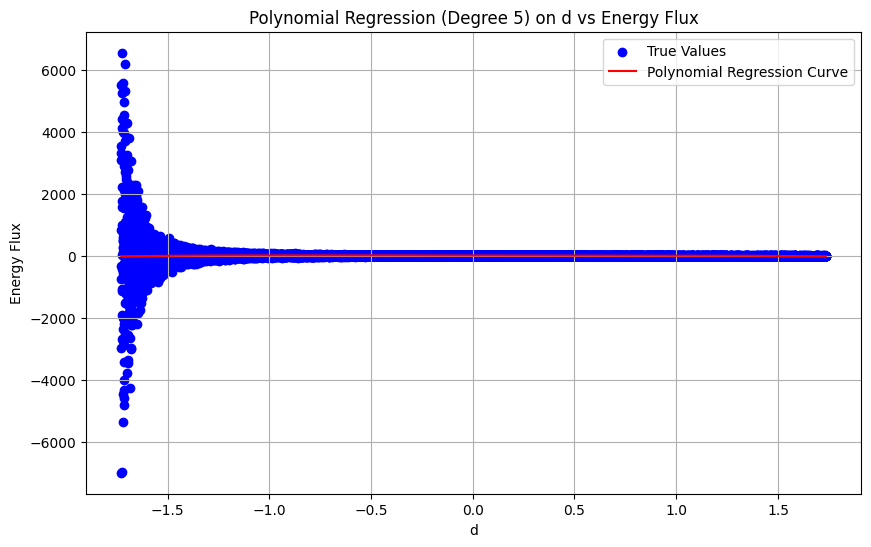

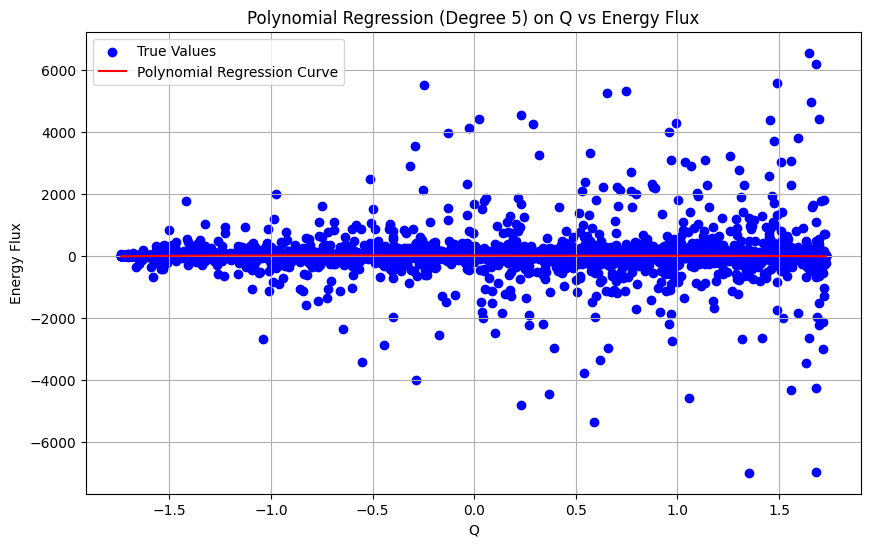

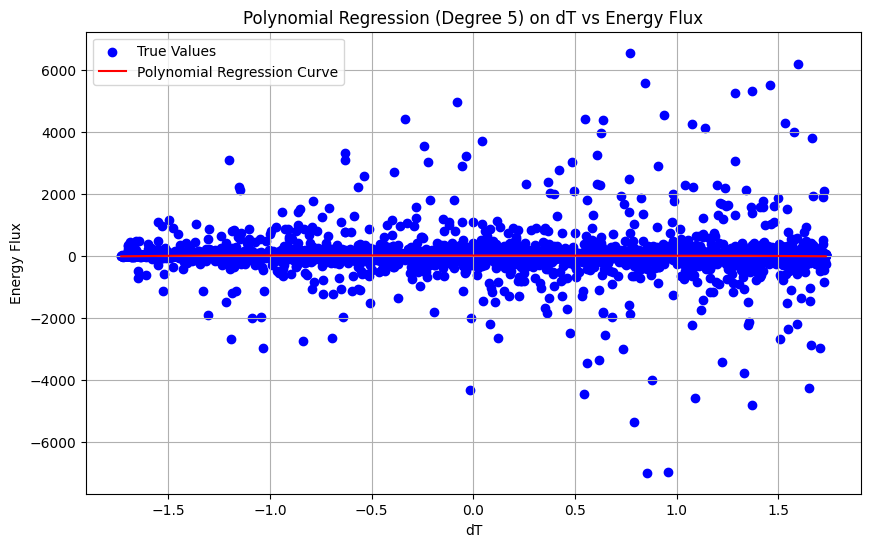

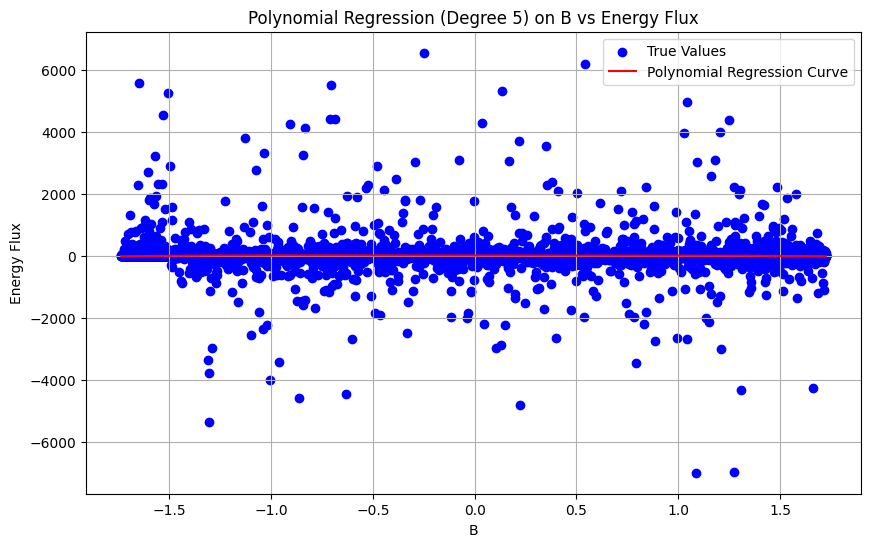

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

class PolynomialRegressionModel:
    def __init__(self, data_path, degree=5, alpha=1.0, test_size=0.2, random_state=42):
        # Initialization: load dataset, set hyperparameters
        self.data_path = data_path
        self.degree = degree
        self.alpha = alpha
        self.test_size = test_size
        self.random_state = random_state

        # Prepare data containers
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

        self.model = None
        self.poly = PolynomialFeatures(degree=self.degree)
        self.scaler = StandardScaler()

    def load_data(self):
        # Load the dataset
        data = pd.read_csv(self.data_path)
        X = data[['d', 'B', 'Q', 'dT']]  # Original Features
        y = data['E']  # Target variable

        # Drop rows with NaN values
        data = pd.concat([X, y], axis=1)
        data = data.dropna()  # Drop rows with any NaN values
        X = data[['d', 'B', 'Q', 'dT']]  # Features again
        y = data['E']  # Target again

        # Create engineered features based on the given formula
        X['sin_BQ'] = np.sin(1.002 * X['B'] * X['Q'])
        X['exp_dT'] = np.exp(-1 / (X['dT']**4))
        X['inv_d2'] = 1 / (X['d']**2)

        # Combine these new features with the original ones
        X_combined = X[['d', 'B', 'Q', 'dT', 'sin_BQ', 'exp_dT', 'inv_d2']]

        # Split the data into training and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_combined, y, test_size=self.test_size, random_state=self.random_state)

    def preprocess_data(self):
        # Standardizing the data
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

        # Apply Polynomial Features
        self.X_poly_train = self.poly.fit_transform(self.X_train)
        self.X_poly_test = self.poly.transform(self.X_test)

    def train_model(self):
        # Fit the Ridge regression model (to avoid overfitting)
        self.model = Ridge(alpha=self.alpha)
        self.model.fit(self.X_poly_train, self.y_train)

    def evaluate_model(self):
        # Make predictions and evaluate
        y_pred = self.model.predict(self.X_poly_test)
        mse = mean_squared_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)

        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}")

    def plot_results(self):
        # Visualizations (Actual vs Predicted)
        plt.figure(figsize=(12, 6))

        # Plotting actual vs predicted energy flux
        plt.subplot(1, 2, 1)
        plt.scatter(self.y_test, self.model.predict(self.X_poly_test), color='blue')
        plt.title('Predicted vs Actual Energy Flux')
        plt.xlabel('Actual Energy Flux')
        plt.ylabel('Predicted Energy Flux')
        plt.grid(True)

        # Plotting residuals
        plt.subplot(1, 2, 2)
        plt.scatter(self.model.predict(self.X_poly_test), self.model.predict(self.X_poly_test) - self.y_test, color='green')
        plt.title('Residuals vs Predicted')
        plt.xlabel('Predicted Energy Flux')
        plt.ylabel('Residuals')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def visualize(self, feature='d'):
    # Visualizing for the chosen feature ('d', 'Q', 'dT', or 'B')
        plt.figure(figsize=(10, 6))

    # Manually map the feature to its column index
        feature_index_map = {
            'd': 0,   # 'd' is the first column
            'B': 1,   # 'B' is the second column
            'Q': 2,   # 'Q' is the third column
            'dT': 3,  # 'dT' is the fourth column
            'sin_BQ': 4, # Additional features after original ones
            'exp_dT': 5,
            'inv_d2': 6
        }

    # Get the column index based on the chosen feature
        feature_index = feature_index_map.get(feature)

        if feature_index is None:
            print(f"Invalid feature '{feature}' selected. Choose from 'd', 'B', 'Q', 'dT', 'sin_BQ', 'exp_dT', 'inv_d2'.")
            return

    # Scatter plot of the original data for the selected feature
        plt.scatter(self.X_test[:, feature_index], self.y_test, color='blue', label='True Values')

    # Fixed values of other features for visualization
        fixed_values = [self.X_test[:, feature_index_map['B']].mean(),
                        self.X_test[:, feature_index_map['Q']].mean(),
                        self.X_test[:, feature_index_map['dT']].mean()]

    # Create a range of values for the feature (e.g., 'd')
        X_range = np.linspace(min(self.X_test[:, feature_index]),
                              max(self.X_test[:, feature_index]), 300).reshape(-1, 1)

    # Combine with the fixed values of the other features
        X_range_full = np.hstack([X_range, np.full((X_range.shape[0], 1), fixed_values[0]),
                                  np.full((X_range.shape[0], 1), fixed_values[1]),
                                  np.full((X_range.shape[0], 1), fixed_values[2]),
                                  np.full((X_range.shape[0], 1), fixed_values[0]),
                                  np.full((X_range.shape[0], 1), fixed_values[1]),
                                  np.full((X_range.shape[0], 1), fixed_values[2])])

    # Apply polynomial feature transformation
        X_range_poly = self.poly.transform(X_range_full)

    # Predict the energy flux for this range of values
        y_range = self.model.predict(X_range_poly)

    # Plot the polynomial regression curve
        plt.plot(X_range, y_range, color='red', label='Polynomial Regression Curve')

        plt.title(f'Polynomial Regression (Degree {self.degree}) on {feature} vs Energy Flux')
        plt.xlabel(f'{feature}')
        plt.ylabel('Energy Flux')
        plt.legend()
        plt.grid(True)
        plt.show()




# Example usage of the class
data_path = 'Classified-BioFluidsLab-IITK-JDexperiment.csv'
model = PolynomialRegressionModel(data_path)

# Loading, preprocessing, training and evaluation
model.load_data()
model.preprocess_data()
model.train_model()
model.evaluate_model()

# Visualize the results for different features
model.visualize(feature='d')
model.visualize(feature='Q')
model.visualize(feature='dT')
model.visualize(feature='B')
